# Spectral Derivatives with Arbitrary Domains

For a Fourier-based spectral method to work out of the box, the function has to be periodic on $[0, 2\pi)$, and for a Chebyshev-based method to work, we have to sample the function at cosine-spaced points on $[1, -1]$. But what if we want to find the derivatives of a function on a different domain?

In principle we can scale and shift, use one of our functions, and scale and shift back, but the details are tricky, worth exemplifying.

In [1]:
import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv, fourier_deriv
import numpy as np
from matplotlib import pyplot

## Chebyshev

Let's use our same $e^t \sin(5t)$ as [before](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev.ipynb), but this time take its derivative on the interval $[1, 4]$.

To convert between domains we use:

$$x \in [1, -1] \leftrightarrow t \in [1,-1] \cdot \frac{t_N - t_0}{2} + \frac{t_N + t_0}{2}$$
$$x_n \in \cos(\frac{\pi [0, N]}{N}) \leftrightarrow t_n \in \cos(\frac{\pi [0, N]}{N}) \cdot \frac{t_N - t_0}{2} + \frac{t_N + t_0}{2} $$

In [16]:
N = 20
x_n = np.cos(np.arange(N+1) * np.pi / N)

t_0 = -4 # Notice the higher end is at the first index of the domain
t_N = -7

scale = (t_0 - t_N)/2
offset = (t_0 + t_N)/2
t_n = np.cos(np.arange(N+1) * np.pi / N) * scale + offset # Sample the function at t_n

t = np.linspace(t_N, t_0, 100) # A denser set of points over the domain, for plotting

If we now sample our function at these $t_n$, it's as if we've smooshed it in to the $[-1, 1]$ domain. Try it for yourself to get an intuition! Put these two in to [Desmos](https://www.desmos.com/calculator):

```
e^{x}\sin(5x)\left\{1\le x\le4\right\}
e^{(\frac{3}{2}x\ +\ \frac{5}{2})}\sin(5\ (\frac{3}{2}x+\frac{5}{2}))\ \left\{-1\le x\le1\right\}
```

Notice that because we've scaled the *length* of the interval, everything has become more or less steep depending on the relative length of the interval in $t$ versus in $x$. This will scale the derivative by exactly $\frac{t_N - t_0}{2}$, and it will scale higher-order derivatives by exactly $\big( \frac{t_N - t_0}{2} \big)^\nu$!

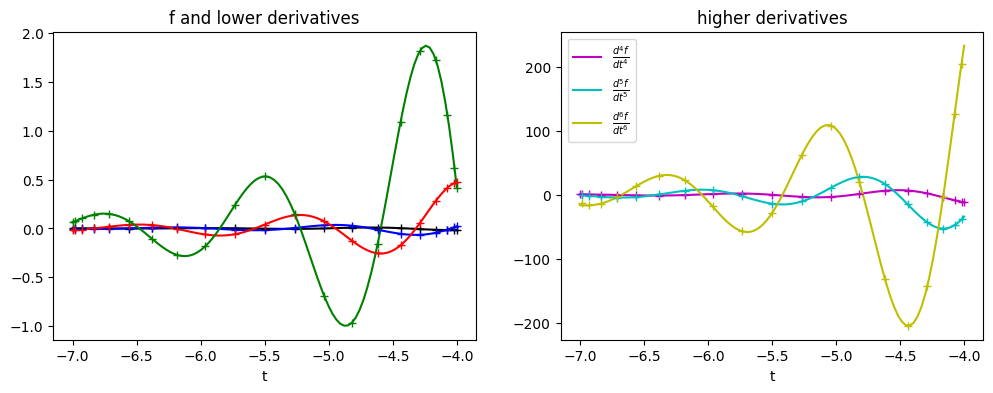

In [17]:
# You can evaluate these with WolframAlpha or by hand.
y = np.exp(t) * np.sin(5*t)
dy = 5*np.exp(t) * np.cos(5*t) + y
d2y = 2*np.exp(t) * (5*np.cos(5*t) - 12*np.sin(5*t))
d3y = -2*np.exp(t) * (37*np.sin(5*t) + 55*np.cos(5*t))
d4y = 4*np.exp(t) * (119*np.sin(5*t) - 120*np.cos(5*t))
d5y = 4*np.exp(t) * (719*np.sin(5*t) + 475*np.cos(5*t))
d6y = 8*np.exp(t) * (2035*np.cos(5*t) - 828*np.sin(5*t))

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(t, y, 'k', label="$f$")
axes[0].plot(t, dy, 'b', label=r"$\frac{df}{dt}$")
axes[0].plot(t, d2y, 'r', label=r"$\frac{d^2f}{dt^2}$")
axes[0].plot(t, d3y, 'g', label=r"$\frac{d^3f}{dt^3}$")
axes[0].set_title("f and lower derivatives")
axes[0].set_xlabel('t')
axes[1].plot(t, d4y, 'm', label=r"$\frac{d^4f}{dt^4}$")
axes[1].plot(t, d5y, 'c', label=r"$\frac{d^5f}{dt^5}$")
axes[1].plot(t, d6y, 'y', label=r"$\frac{d^6f}{dt^6}$")
axes[1].set_title("higher derivatives")
axes[1].set_xlabel('t')
axes[1].legend()

# x = cos -> t = cos * (t_N - t_0)/2 + (t_N + t_0)/2
y_n = np.exp(t_n) * np.sin(5*t_n)
dy_n = cheb_deriv(x_n, y_n, 1)/scale # scale by the relative sizes of the t and x intervals
d2y_n = cheb_deriv(x_n, y_n, 2)/scale**2 # scale by the relative sizes of the intervals, but this time squared
d3y_n = cheb_deriv(x_n, y_n, 3)/scale**3 # cubed
d4y_n = cheb_deriv(x_n, y_n, 4)/scale**4 # etc!
d5y_n = cheb_deriv(x_n, y_n, 5)/scale**5
d6y_n = cheb_deriv(x_n, y_n, 6)/scale**6

axes[0].plot(t_n, y_n, 'k+')
axes[0].plot(t_n, dy_n, 'b+')
axes[0].plot(t_n, d2y_n, 'r+')
axes[0].plot(t_n, d3y_n, 'g+')
axes[1].plot(t_n, d4y_n, 'm+')
axes[1].plot(t_n, d5y_n, 'c+')
axes[1].plot(t_n, d6y_n, 'y+');

## Fourier

Let's use our same $\cos(\theta) + 2\sin(3\theta))$ as [before](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/fourier.ipynb), except this time add a frequency factor, so it's no longer periodic on $[0, 2\pi)$:

$$ \cos(\frac{\pi}{2} t) + 2\sin(\frac{3\pi}{2} t)),\quad t \in [4, 8)$$

Convince yourself this is periodic in the [graphing calculator](https://www.desmos.com/calculator) again:

```
\cos(\frac{\pi}{2}x)\ +\ 2\sin(\frac{3\pi}{2}x)\ \left\{4\le x<8\right\}
```

To get us back to $\theta$ so we can use the spectral method, we convert with

$$\theta \in [0, 2\pi) \leftrightarrow t \in [0, 2\pi) \cdot \frac{t_M - t_0}{2\pi} + t_0$$
$$ \theta \in \frac{[0, M) \cdot 2\pi}{M} \leftrightarrow t_n \in \frac{[0, M) \cdot 2\pi}{M} \cdot \frac{t_M - t_0}{2\pi} + t_0$$

In [36]:
M = 20 # length M, in keeping with the usage of M in my math.pdf notes.
t_0 = 4
t_M = 8

scale = (t_M - t_0)/(2 * np.pi)
offset = t_0
t_n = (np.arange(0, M) * 2*np.pi / M) * scale + offset # It's important this be an *open* periodic domain, or we get artefacting

t = np.linspace(t_0, t_M, 100) # A denser set of points over the domain, for plotting

We can now sample the function at $t_n$, which is as if we've smooshed it in to $[0, 2\pi)$.

[Convince yourself this is true](https://www.desmos.com/calculator):
```
\cos(\frac{\pi}{2}(x\frac{2}{\pi}+4))\ +\ 2\sin(\frac{3\pi}{2}(x\frac{2}{\pi}+4))\ \left\{0\le x<2\pi\right\}
```

Notice that because we've scaled the *length* of the interval, everything has become more or less steep depending on the relative length of the interval in $t$ versus in $\theta$. This will scale the derivative by exactly $\frac{t_M - t_0}{2\pi}$, and it will scale higher-order derivatives by exactly $\big( \frac{t_M - t_0}{2\pi} \big)^\nu$!

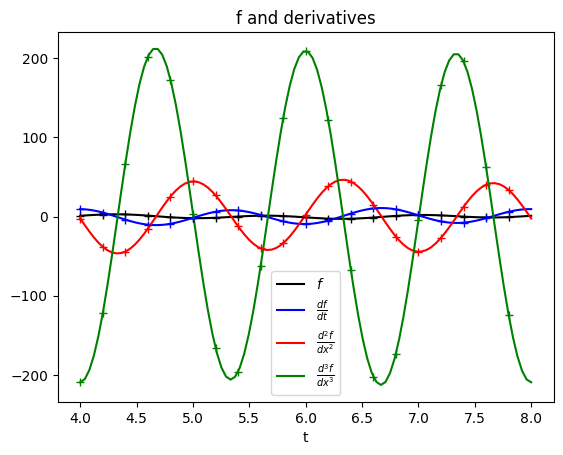

In [45]:
# true function and analytic derivatives. You can evaluate these with WolframAlpha or by hand.
f = np.cos(np.pi/2 * t) + 2*np.sin(3*np.pi/2 * t)
df = 3*np.pi*np.cos(3*np.pi/2 * t) - np.pi/2 * np.sin(np.pi/2 * t) 
d2f = -(np.pi**2)/4 * np.cos(np.pi/2 * t) - (9*np.pi**2)/2 * np.sin(3*np.pi/2 * t)
d3f = (np.pi**3)/8 * np.sin(np.pi/2 * t) - (27*np.pi**3)/4 * np.cos(3*np.pi/2 * t)

pyplot.plot(t, f, 'k', label="$f$")
pyplot.plot(t, df, 'b', label=r"$\frac{df}{dt}$")
pyplot.plot(th, d2f, 'r', label=r"$\frac{d^2f}{dx^2}$")
pyplot.plot(th, d3f, 'g', label=r"$\frac{d^3f}{dx^3}$")
pyplot.title("f and derivatives")
pyplot.xlabel('t')
pyplot.legend()

# sampled function and computed derivatives
y = np.cos(np.pi/2 * t_n) + 2*np.sin(3*np.pi/2 * t_n)
dy = fourier_deriv(y, 1)/scale
d2y = fourier_deriv(y, 2)/scale**2
d3y = fourier_deriv(y, 3)/scale**3

pyplot.plot(t_n, y, 'k+')
pyplot.plot(t_n, dy, 'b+')
pyplot.plot(t_n, d2y, 'r+')
pyplot.plot(t_n, d3y, 'g+');